epoch: 0, loss: 2.31, train_acc: 0.12
epoch: 0, loss: 0.57, train_acc: 0.74
epoch: 0, loss: 0.42, train_acc: 0.78
epoch: 0, loss: 0.44, train_acc: 0.79
epoch: 1, loss: 0.46, train_acc: 0.84
epoch: 1, loss: 0.45, train_acc: 0.83
epoch: 1, loss: 0.35, train_acc: 0.84
epoch: 1, loss: 0.44, train_acc: 0.84
epoch: 2, loss: 0.39, train_acc: 0.86
epoch: 2, loss: 0.38, train_acc: 0.84
epoch: 2, loss: 0.33, train_acc: 0.85
epoch: 2, loss: 0.43, train_acc: 0.85
epoch: 3, loss: 0.37, train_acc: 0.86
epoch: 3, loss: 0.33, train_acc: 0.85
epoch: 3, loss: 0.31, train_acc: 0.85
epoch: 3, loss: 0.36, train_acc: 0.85
epoch: 4, loss: 0.39, train_acc: 0.84
epoch: 4, loss: 0.34, train_acc: 0.85
epoch: 4, loss: 0.31, train_acc: 0.86
epoch: 4, loss: 0.34, train_acc: 0.86


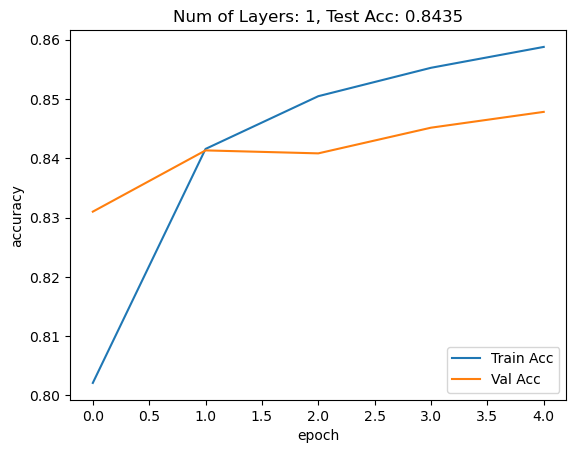

epoch: 0, loss: 2.30, train_acc: 0.08
epoch: 0, loss: 0.54, train_acc: 0.74
epoch: 0, loss: 0.48, train_acc: 0.79
epoch: 0, loss: 0.33, train_acc: 0.81
epoch: 1, loss: 0.43, train_acc: 0.84
epoch: 1, loss: 0.44, train_acc: 0.86
epoch: 1, loss: 0.42, train_acc: 0.86
epoch: 1, loss: 0.30, train_acc: 0.86
epoch: 2, loss: 0.37, train_acc: 0.85
epoch: 2, loss: 0.38, train_acc: 0.87
epoch: 2, loss: 0.40, train_acc: 0.87
epoch: 2, loss: 0.33, train_acc: 0.87
epoch: 3, loss: 0.40, train_acc: 0.86
epoch: 3, loss: 0.40, train_acc: 0.87
epoch: 3, loss: 0.39, train_acc: 0.87
epoch: 3, loss: 0.25, train_acc: 0.88
epoch: 4, loss: 0.39, train_acc: 0.85
epoch: 4, loss: 0.32, train_acc: 0.88
epoch: 4, loss: 0.36, train_acc: 0.88
epoch: 4, loss: 0.27, train_acc: 0.88


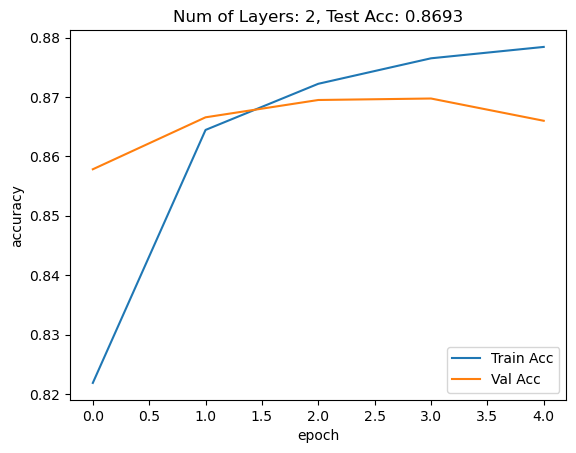

epoch: 0, loss: 2.30, train_acc: 0.15
epoch: 0, loss: 1.61, train_acc: 0.38
epoch: 0, loss: 1.48, train_acc: 0.42
epoch: 0, loss: 1.58, train_acc: 0.43
epoch: 1, loss: 1.47, train_acc: 0.52
epoch: 1, loss: 1.53, train_acc: 0.46
epoch: 1, loss: 1.47, train_acc: 0.46
epoch: 1, loss: 1.62, train_acc: 0.46
epoch: 2, loss: 1.41, train_acc: 0.53
epoch: 2, loss: 1.49, train_acc: 0.47
epoch: 2, loss: 1.44, train_acc: 0.47
epoch: 2, loss: 1.58, train_acc: 0.47
epoch: 3, loss: 1.32, train_acc: 0.55
epoch: 3, loss: 1.47, train_acc: 0.47
epoch: 3, loss: 1.45, train_acc: 0.47
epoch: 3, loss: 1.62, train_acc: 0.47
epoch: 4, loss: 1.32, train_acc: 0.54
epoch: 4, loss: 1.44, train_acc: 0.47
epoch: 4, loss: 1.43, train_acc: 0.47
epoch: 4, loss: 1.54, train_acc: 0.47


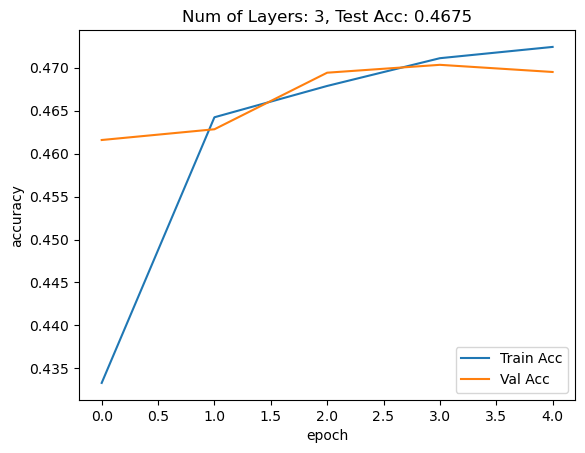

epoch: 0, loss: 2.30, train_acc: 0.08
epoch: 0, loss: 1.47, train_acc: 0.38
epoch: 0, loss: 1.34, train_acc: 0.43
epoch: 0, loss: 1.24, train_acc: 0.44
epoch: 1, loss: 1.25, train_acc: 0.47
epoch: 1, loss: 1.29, train_acc: 0.47
epoch: 1, loss: 1.33, train_acc: 0.48
epoch: 1, loss: 1.15, train_acc: 0.48
epoch: 2, loss: 1.27, train_acc: 0.45
epoch: 2, loss: 1.22, train_acc: 0.48
epoch: 2, loss: 1.34, train_acc: 0.49
epoch: 2, loss: 1.14, train_acc: 0.48
epoch: 3, loss: 1.24, train_acc: 0.48
epoch: 3, loss: 1.19, train_acc: 0.48
epoch: 3, loss: 1.34, train_acc: 0.49
epoch: 3, loss: 1.12, train_acc: 0.49
epoch: 4, loss: 1.25, train_acc: 0.47
epoch: 4, loss: 1.21, train_acc: 0.48
epoch: 4, loss: 1.36, train_acc: 0.49
epoch: 4, loss: 1.12, train_acc: 0.49


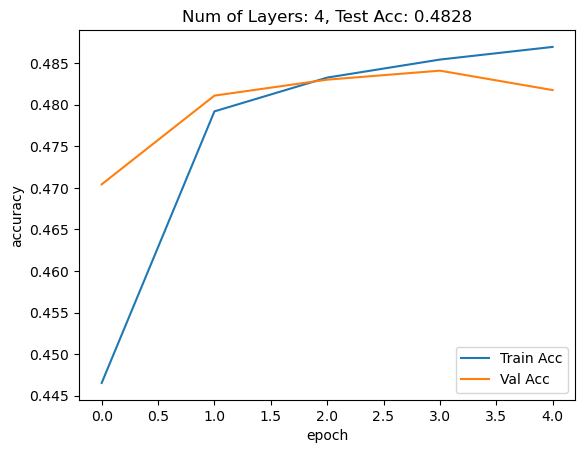

In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F


train_set = datasets.MNIST("./mnist/train", train=True, transform=transforms.ToTensor(), download=True)
test_set = datasets.MNIST("./mnist/test", train=False, transform=transforms.ToTensor(), download=True)

# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_set)),
    train_set.targets,
    stratify=train_set.targets,
    train_size=0.8,
)

# generate subset based on indices
train_split = Subset(train_set, train_indices)
val_split = Subset(train_set, val_indices)


train_loader = DataLoader(train_split, batch_size=128)
val_loader = DataLoader(val_split, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()


        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # last layer is output size 
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.layers.append(nn.Linear(hidden_size, output_size))
        
        # print(self.layers) # verified to work
        

        """
        End of Implement
        """

    def forward(self, x):
        dims = x.size()
        x.reshape(dims[0], 28 * 28)
        for layer in self.layers:
            x = F.relu(layer(x)) # RelU around layer
        return x

    # Training function
def train(model, criterion, optimizer, train_loader, val_loader, n_epochs):
    train_acc, val_acc = [], []
    for epoch in range(n_epochs):
        # Training
        model.train()
        correct, total = 0, 0
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            # getting outputs
            outputs = model(inputs)
            
            # calculating loss
            loss = criterion(outputs, labels)
            
            # backpropagation
            
            loss.backward() 
            optimizer.step()
            optimizer.zero_grad()

            predicted = outputs.argmax(dim=1)

            ## your code here

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if idx % 100 == 0:
                print(f"epoch: {epoch}, loss: {loss:.2f}, train_acc: {(correct/total):.2f}")

        train_acc.append(correct/total)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                inputs = inputs.view(inputs.size(0), -1)
                outputs = model(inputs)
                predicted = outputs.argmax(dim=1)



                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_acc.append(correct/total)

    return train_acc, val_acc

# Testing function
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            predicted = outputs.argmax(dim=1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct/total


input_size = 28*28
hidden_size = 32
output_size = 10
num_layers = [1, 2, 3, 4]
n_epochs = 5
lr = 0.01

# Training, Validation, and Testing
for num_layer in num_layers:
    model = MLP(input_size, hidden_size, num_layer, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_acc, val_acc = train(model, criterion, optimizer, train_loader, val_loader, n_epochs)
    test_acc = test(model, test_loader)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend(loc='lower right')
    plt.title(f'Num of Layers: {num_layer}, Test Acc: {test_acc}')
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.show()